<a href="https://colab.research.google.com/github/b4wolf/NEURALNETS/blob/main/model_lstm_12_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
from sklearn.impute import SimpleImputer

In [2]:
!pip install torch.geometric networkx torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.7 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import timedelta
import os
from google.colab import files
torch.manual_seed(1)
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.nn import GCNConv

# Ignore everything above

In [4]:
"""def impute_data(raw_data_path, year):
  df = pd.read_parquet(raw_data_path)
  df_filtered = df[df['valid'].dt.year.isin([2021, 2021])]
  df = pd.DataFrame(df_filtered)
  df = df.set_index('valid')
  df.index = df.index.floor('H')

  start_date = pd.to_datetime(f'{year}-01-01').floor('D')
  end_date = pd.to_datetime(f'{year+1}-01-01').floor('D') - timedelta(hours=1)
  complete_index = pd.date_range(start=start_date, end=end_date, freq='1H')
  complete_df = pd.DataFrame(index=complete_index)

  merged_df = complete_df.merge(df, left_index=True, right_index=True, how='left')
  merged_df = merged_df[~merged_df.index.duplicated(keep='first')]
  imputed_df = merged_df.fillna(method='ffill')
  return imputed_df

for filename in os.listdir('./raw_WI_data'):
    if '.parquet' not in filename:
      continue
    dataframe = impute_data('./raw_WI_data/' + filename, 2021)
    if len(dataframe) == 8760:
      file = dataframe.to_csv(f'./clean_WI_data/{filename[:3]}.csv')
"""

"def impute_data(raw_data_path, year):\n  df = pd.read_parquet(raw_data_path)\n  df_filtered = df[df['valid'].dt.year.isin([2021, 2021])]\n  df = pd.DataFrame(df_filtered)\n  df = df.set_index('valid')\n  df.index = df.index.floor('H')\n\n  start_date = pd.to_datetime(f'{year}-01-01').floor('D')\n  end_date = pd.to_datetime(f'{year+1}-01-01').floor('D') - timedelta(hours=1)\n  complete_index = pd.date_range(start=start_date, end=end_date, freq='1H')\n  complete_df = pd.DataFrame(index=complete_index)\n\n  merged_df = complete_df.merge(df, left_index=True, right_index=True, how='left')\n  merged_df = merged_df[~merged_df.index.duplicated(keep='first')]\n  imputed_df = merged_df.fillna(method='ffill')\n  return imputed_df\n\nfor filename in os.listdir('./raw_WI_data'):\n    if '.parquet' not in filename:\n      continue\n    dataframe = impute_data('./raw_WI_data/' + filename, 2021)\n    if len(dataframe) == 8760:\n      file = dataframe.to_csv(f'./clean_WI_data/{filename[:3]}.csv')\n"

In [5]:
station_data = []
for filename in os.listdir('.'):
  if '.csv' in filename:
    pm25_df = pd.read_csv(filename)
    station_data.append(np.array(pm25_df["Value"].values).reshape(-1, 1))

In [6]:
# from https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
# Creates a series of lookback windows to be used for training and predicting window t+1
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return np.array(X), np.array(y)

In [7]:
normalized_station_data = []
for stat in station_data:
  train_size = int(len(stat) * 0.70)
  test_size = len(stat) - train_size

  #stat = stat.astype('float32')
  stat_train, stat_test = stat[:train_size], stat[train_size:]
  #scaler = preprocessing.StandardScaler().fit(stat_train)
  #stat_train = scaler.transform(stat_train)
  #stat_test = scaler.transform(stat_test)

  normalized_station_data.append([stat_train, stat_test])

print(len(normalized_station_data))

11


In [8]:
lookback = 7
station_train_dataset = []
station_test_dataset = []
for stat in normalized_station_data:
  X_train, y_train = create_dataset(stat[0], lookback=lookback)
  X_test, y_test = create_dataset(stat[1], lookback=lookback)
  station_train_dataset.append([X_train, y_train])
  station_test_dataset.append([X_test, y_test])

In [9]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=100, num_layers=1, batch_first=True)
        self.linear = nn.Linear(in_features=100, out_features=input_size)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [10]:
def plot(model, timeseries, train_size, X_train, y_train, X_test, y_test):
  with torch.no_grad():
      # shift train predictions for plotting
      train_plot = np.ones_like(timeseries[:,0]) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1, 0]
      train_plot[lookback:train_size] = y_pred
      # shift test predictions for plotting
      y_pred = model(X_test)
      y_pred = y_pred[:, -1, 0]
      test_plot = np.ones_like(timeseries[:,0]) * np.nan
      test_plot[train_size+lookback:len(timeseries[:,0])] = y_pred
  # plot
  plt.plot(timeseries[:,0], c='#FFFDD0')
  plt.show()
  plt.plot(train_plot, c='r')
  plt.plot(test_plot, c='g')
  #plt.xlim(7250, 7750)
  plt.show()

In [11]:
# plt.title("PM 2.5 RMSE Loss Per Epoch")
# plt.plot(pm25_losses, label="pm25 loss")
# plt.show()

<ipython-input-12-7040da09b11b>:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(X), torch.tensor(y)


Epoch 0: train RMSE 3.9289, test RMSE 3.0530
Epoch 1: train RMSE 3.1081, test RMSE 2.6896
Epoch 2: train RMSE 2.8109, test RMSE 2.6184
Epoch 3: train RMSE 2.6371, test RMSE 2.6021
Epoch 4: train RMSE 2.5326, test RMSE 2.6133
Epoch 5: train RMSE 2.4490, test RMSE 2.6134
Epoch 6: train RMSE 2.3977, test RMSE 2.6311
Epoch 7: train RMSE 2.3598, test RMSE 2.6658
Epoch 8: train RMSE 2.3047, test RMSE 2.6635
Epoch 9: train RMSE 2.3085, test RMSE 2.6920
torch.Size([6125, 1])


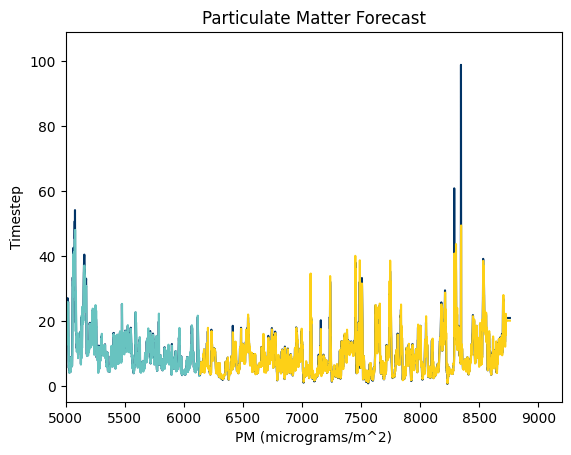

Epoch 0: train RMSE 3.1950, test RMSE 1.9598
Epoch 1: train RMSE 2.4645, test RMSE 1.8260
Epoch 2: train RMSE 2.1690, test RMSE 1.8207
Epoch 3: train RMSE 2.0104, test RMSE 1.8219
Epoch 4: train RMSE 1.9277, test RMSE 1.8346
Epoch 5: train RMSE 1.9219, test RMSE 1.8874
Epoch 6: train RMSE 1.8068, test RMSE 1.8480
Epoch 7: train RMSE 1.7874, test RMSE 1.8473
Epoch 8: train RMSE 1.7721, test RMSE 1.8560
Epoch 9: train RMSE 1.7325, test RMSE 1.8380
torch.Size([6125, 1])


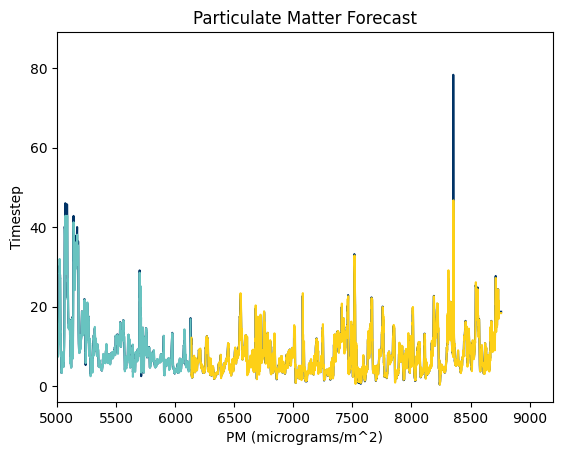

Epoch 0: train RMSE 3.7935, test RMSE 3.0112
Epoch 1: train RMSE 2.8089, test RMSE 2.5852
Epoch 2: train RMSE 2.4769, test RMSE 2.4978
Epoch 3: train RMSE 2.3071, test RMSE 2.4698
Epoch 4: train RMSE 2.2230, test RMSE 2.4777
Epoch 5: train RMSE 2.1775, test RMSE 2.4904
Epoch 6: train RMSE 2.1085, test RMSE 2.4531
Epoch 7: train RMSE 2.0747, test RMSE 2.4603
Epoch 8: train RMSE 2.0478, test RMSE 2.4534
Epoch 9: train RMSE 2.0298, test RMSE 2.4629
torch.Size([6125, 1])


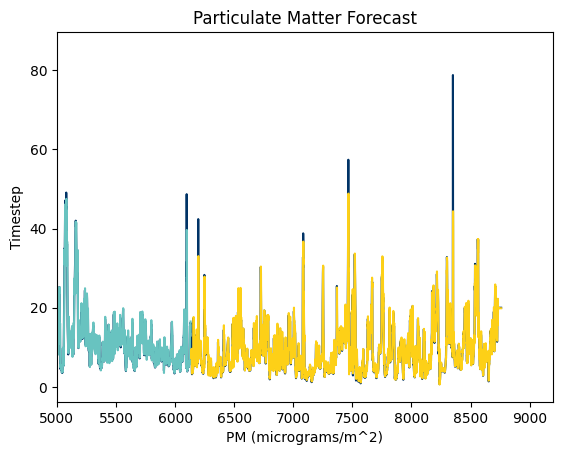

Epoch 0: train RMSE 2.9536, test RMSE 1.9517
Epoch 1: train RMSE 2.1269, test RMSE 1.7784
Epoch 2: train RMSE 1.8590, test RMSE 1.7151
Epoch 3: train RMSE 1.7277, test RMSE 1.7112
Epoch 4: train RMSE 1.6457, test RMSE 1.6699
Epoch 5: train RMSE 1.5933, test RMSE 1.6611
Epoch 6: train RMSE 1.5708, test RMSE 1.6573
Epoch 7: train RMSE 1.5492, test RMSE 1.6515
Epoch 8: train RMSE 1.5342, test RMSE 1.6543
Epoch 9: train RMSE 1.5377, test RMSE 1.6718
torch.Size([6125, 1])


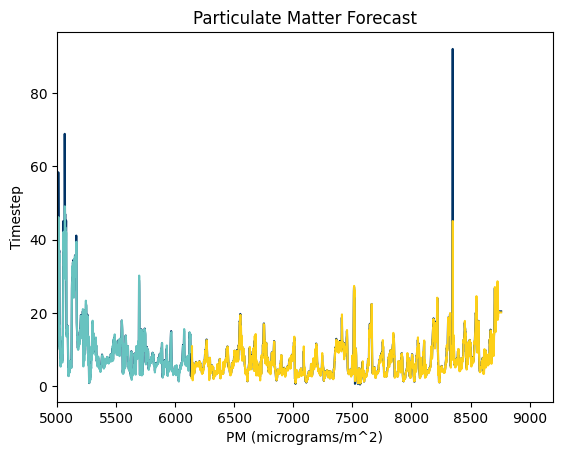

Epoch 0: train RMSE 3.0099, test RMSE 2.4655
Epoch 1: train RMSE 2.1834, test RMSE 2.2164
Epoch 2: train RMSE 1.8787, test RMSE 2.1795
Epoch 3: train RMSE 1.7301, test RMSE 2.1636
Epoch 4: train RMSE 1.6540, test RMSE 2.1703
Epoch 5: train RMSE 1.6156, test RMSE 2.1855
Epoch 6: train RMSE 1.5705, test RMSE 2.1796
Epoch 7: train RMSE 1.5896, test RMSE 2.2029
Epoch 8: train RMSE 1.5588, test RMSE 2.1898
Epoch 9: train RMSE 1.5684, test RMSE 2.1948
torch.Size([6125, 1])


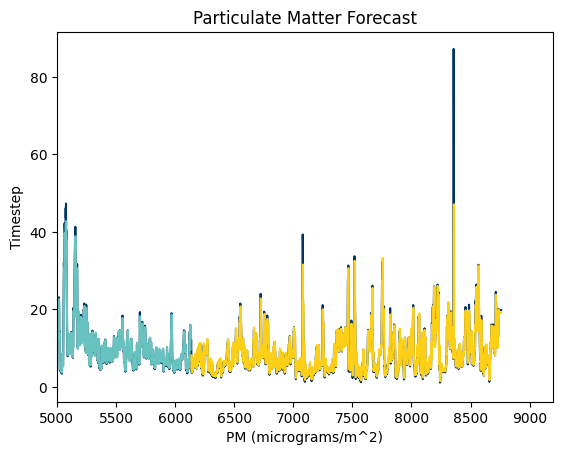

Epoch 0: train RMSE 5.7412, test RMSE 2.2827
Epoch 1: train RMSE 4.9134, test RMSE 2.1080
Epoch 2: train RMSE 4.6175, test RMSE 2.0373
Epoch 3: train RMSE 4.0903, test RMSE 1.9284
Epoch 4: train RMSE 3.8523, test RMSE 1.8634
Epoch 5: train RMSE 3.6715, test RMSE 1.8096
Epoch 6: train RMSE 3.4908, test RMSE 1.8211
Epoch 7: train RMSE 3.3691, test RMSE 1.7627
Epoch 8: train RMSE 3.2800, test RMSE 1.7716
Epoch 9: train RMSE 3.1418, test RMSE 1.7987
torch.Size([6125, 1])


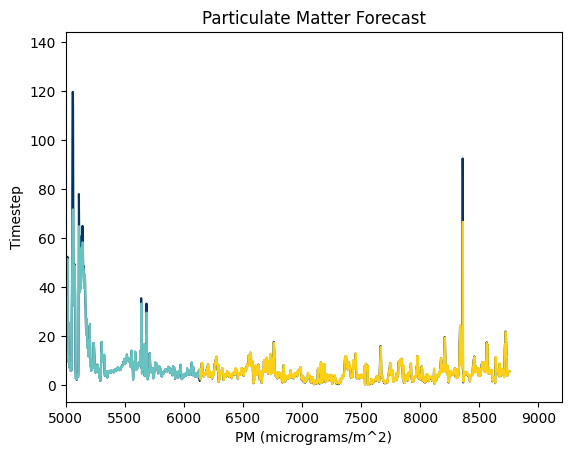

Epoch 0: train RMSE 2.7275, test RMSE 1.6157
Epoch 1: train RMSE 2.0354, test RMSE 1.5530
Epoch 2: train RMSE 1.7921, test RMSE 1.5719
Epoch 3: train RMSE 1.6562, test RMSE 1.5722
Epoch 4: train RMSE 1.5773, test RMSE 1.5564
Epoch 5: train RMSE 1.5621, test RMSE 1.5611
Epoch 6: train RMSE 1.5107, test RMSE 1.5718
Epoch 7: train RMSE 1.5179, test RMSE 1.5679
Epoch 8: train RMSE 1.4876, test RMSE 1.5758
Epoch 9: train RMSE 1.4819, test RMSE 1.5837
torch.Size([6125, 1])


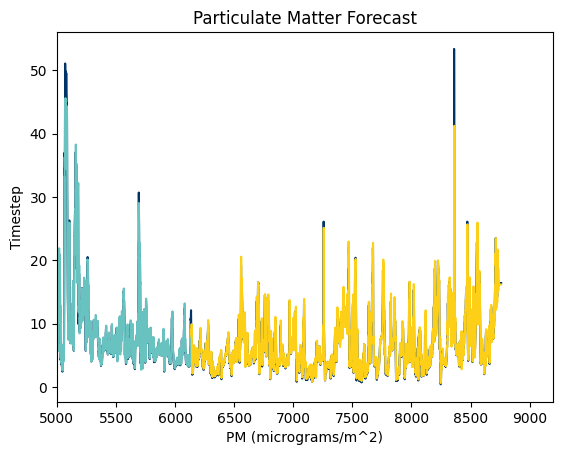

Epoch 0: train RMSE 5.4017, test RMSE 1.5154
Epoch 1: train RMSE 4.6264, test RMSE 1.3755
Epoch 2: train RMSE 4.2440, test RMSE 1.3515
Epoch 3: train RMSE 4.0246, test RMSE 1.3962
Epoch 4: train RMSE 3.8561, test RMSE 1.3583
Epoch 5: train RMSE 3.7584, test RMSE 1.3690
Epoch 6: train RMSE 3.7112, test RMSE 1.4343
Epoch 7: train RMSE 3.6336, test RMSE 1.4267
Epoch 8: train RMSE 3.6044, test RMSE 1.4230
Epoch 9: train RMSE 3.5813, test RMSE 1.4314
torch.Size([6125, 1])


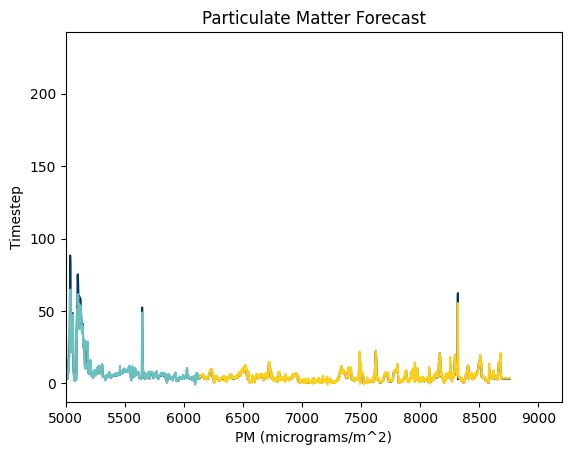

Epoch 0: train RMSE 3.9938, test RMSE 1.9208
Epoch 1: train RMSE 3.1032, test RMSE 1.8724
Epoch 2: train RMSE 2.6855, test RMSE 1.8223
Epoch 3: train RMSE 2.4644, test RMSE 1.8312
Epoch 4: train RMSE 2.3184, test RMSE 1.8038
Epoch 5: train RMSE 2.2754, test RMSE 1.8046
Epoch 6: train RMSE 2.1854, test RMSE 1.8137
Epoch 7: train RMSE 2.1438, test RMSE 1.8314
Epoch 8: train RMSE 2.1163, test RMSE 1.8501
Epoch 9: train RMSE 2.1112, test RMSE 1.8427
torch.Size([6125, 1])


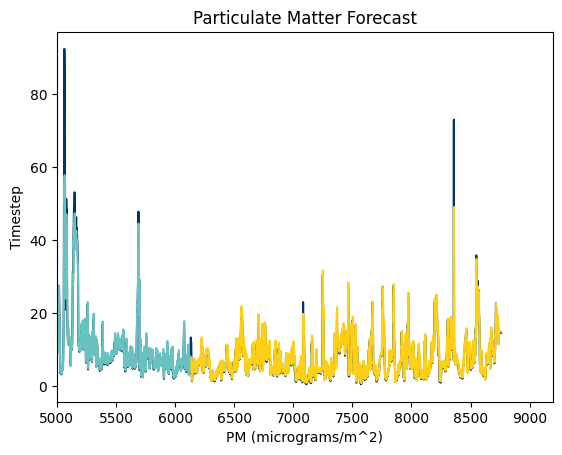

Epoch 0: train RMSE 4.4588, test RMSE 2.3551
Epoch 1: train RMSE 3.4430, test RMSE 2.1399
Epoch 2: train RMSE 2.9209, test RMSE 2.0680
Epoch 3: train RMSE 2.6076, test RMSE 2.0509
Epoch 4: train RMSE 2.4469, test RMSE 2.0731
Epoch 5: train RMSE 2.2762, test RMSE 2.0309
Epoch 6: train RMSE 2.1699, test RMSE 2.0458
Epoch 7: train RMSE 2.1083, test RMSE 2.0801
Epoch 8: train RMSE 1.9951, test RMSE 2.0595
Epoch 9: train RMSE 1.9660, test RMSE 2.0607
torch.Size([6125, 1])


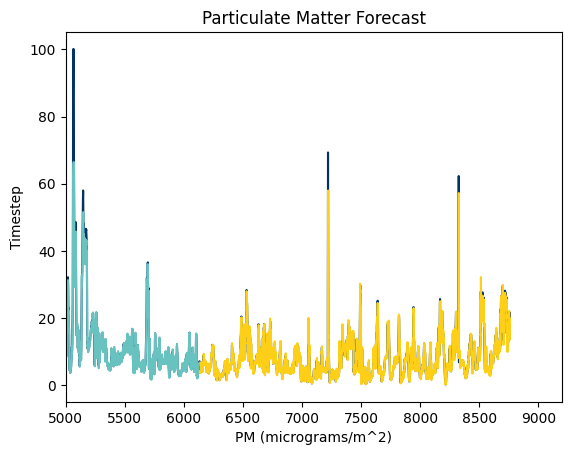

Epoch 0: train RMSE 3.3627, test RMSE 2.6563
Epoch 1: train RMSE 2.5212, test RMSE 2.4194
Epoch 2: train RMSE 2.2364, test RMSE 2.3291
Epoch 3: train RMSE 2.0684, test RMSE 2.3045
Epoch 4: train RMSE 1.9898, test RMSE 2.2720
Epoch 5: train RMSE 1.9379, test RMSE 2.2553
Epoch 6: train RMSE 1.9660, test RMSE 2.2864
Epoch 7: train RMSE 1.8837, test RMSE 2.2644
Epoch 8: train RMSE 1.8724, test RMSE 2.2467
Epoch 9: train RMSE 1.9013, test RMSE 2.2952
torch.Size([6125, 1])


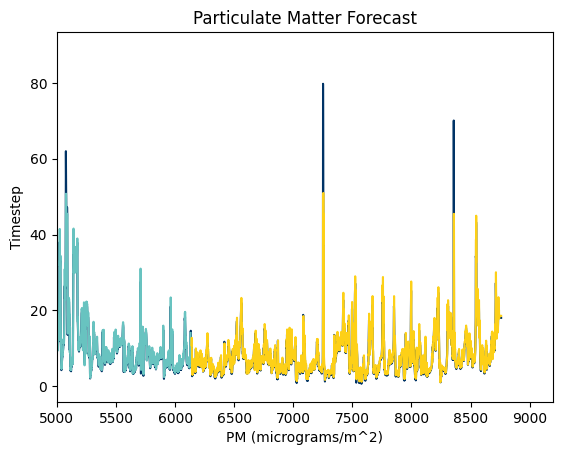

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

station_data = []
for filename in os.listdir('.'):
  if '.csv' in filename:
    df = pd.read_csv(filename)
    timeseries = df[["Value"]].values.astype('float32')
    station_data.append(timeseries)

stat_train_predictions = []
stat_test_predictions = []
#timeseries[7760:k]
# train-test split for time series
for timeseries in station_data:
  train_size = int(len(timeseries) * 0.70)
  test_size = len(timeseries) - train_size
  train, test = timeseries[:train_size], timeseries[train_size:]

  def create_dataset(dataset, lookback):
      """Transform a time series into a prediction dataset

      Args:
          dataset: A numpy array of time series, first dimension is the time steps
          lookback: Size of window for prediction
      """
      X, y = [], []
      for i in range(len(dataset)-lookback):
          feature = dataset[i:i+lookback]
          target = dataset[i+1:i+lookback+1]
          X.append(feature)
          y.append(target)
      return torch.tensor(X), torch.tensor(y)

  lookback = 7
  X_train, y_train = create_dataset(train, lookback=lookback)
  X_test, y_test = create_dataset(test, lookback=lookback)
  class AirModel(nn.Module):
      def __init__(self):
          super().__init__()
          self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
          self.linear = nn.Linear(50, 1)
      def forward(self, x):
          x, _ = self.lstm(x)
          x = self.linear(x)
          return x

  model = AirModel()
  optimizer = optim.Adam(model.parameters())
  loss_fn = nn.MSELoss()
  loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

  n_epochs = 10
  for epoch in range(n_epochs):
      model.train()
      losses = []
      for X_batch, y_batch in loader:
          y_pred = model(X_batch)
          loss = loss_fn(y_pred, y_batch)
          losses.append(loss.detach().numpy())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      # Validation
      model.eval()
      with torch.no_grad():
          y_pred = model(X_train)
          train_rmse = np.sqrt(loss_fn(y_pred, y_train))
          y_pred = model(X_test)
          test_rmse = np.sqrt(loss_fn(y_pred, y_test))
      print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

  with torch.no_grad():
      # shift train predictions for plotting
      train_plot = np.ones_like(timeseries) * np.nan
      y_pred = model(X_train)
      stat_train_predictions.append(y_pred[: -1, :])

      y_pred = y_pred[:, -1, :]
      print(y_pred.shape)
      train_plot[lookback:train_size] = model(X_train)[:, -1, :]
      # shift test predictions for plotting
      test_plot = np.ones_like(timeseries) * np.nan
      y_pred = model(X_test)
      stat_test_predictions.append(y_pred[:, -1, :])
      test_plot[train_size+lookback:len(timeseries)] = y_pred[:, -1, :]
  # plot
  plt.plot(timeseries, color='#003366')  # Cream for the main timeseries
  plt.plot(train_plot, color='#68C3C0')  # Gentle Metallic Blue for train plot
  plt.plot(test_plot, color='#FDD017')   # Light Gold for test plot
  plt.title('Particulate Matter Forecast')
  plt.xlabel("PM (micrograms/m^2)")
  plt.ylabel("Timestep")
  plt.xlim(left=5000)
  plt.savefig(f'{timeseries}transparent_plot.png', transparent=True)
  plt.show()

In [13]:
stat_train_predictions[0].shape

torch.Size([6124, 7, 1])

# Try try again, closer version

note that the files for processed monitor are stored in content when on colab but might be different when local

In [14]:
import torch
import folium
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from scipy.spatial.distance import euclidean
import os
import networkx as nx
from torch_geometric.data import Data
import math
from heapq import nsmallest
import pandas as pd
import re
import glob
import matplotlib.pyplot as plt
import torch.optim as optim

In [15]:
directory_path = '/content/'
file_names = [file for file in os.listdir(directory_path) if 'monitor' in file and file.endswith('.csv')]
data_frames = []

for file_name in file_names:
    match = re.match(r'processed_monitor_([0-9.-]+)_([0-9.-]+)\.csv', file_name)
    if match:
        lat, lon = match.groups()
        lat, lon = float(lat), float(lon)
        try:
            df = pd.read_csv(os.path.join(directory_path, file_name))
            df['Latitude'] = lat
            df['Longitude'] = lon
            data_frames.append(df)
        except FileNotFoundError:
            print(f"File not found: {file_name}")
        except pd.errors.EmptyDataError:
            print(f"No data in file: {file_name}")
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")
    else:
        print(f"Filename pattern mismatch: {file_name}")

In [16]:
directory_path = '/content/'
file_names = glob.glob(os.path.join(directory_path, '*.csv'))

In [17]:
# import os
# import json

# # Directory containing the JSON files
# directory = directory_path

# # List to store all lat-lon pairs
# lat_lons = []

# # Iterate through each file in the directory
# for filename in os.listdir(directory):
#     if filename.endswith('.json'):
#         file_path = os.path.join(directory, filename)

#         # Open and read the JSON file
#         with open(file_path, 'r') as file:
#             data = json.load(file)

#             # Extract the lat-lon pair
#             lat_lon = data.get('lat_lon')
#             if lat_lon is not None and len(lat_lon) == 2:
#                 lat_lons.append(tuple(lat_lon))

# print(lat_lons)


In [18]:
def haversine(coord1, coord2):
    R = 6371.0
    lat1, lon1 = math.radians(coord1[0]), math.radians(coord1[1])
    lat2, lon2 = math.radians(coord2[0]), math.radians(coord2[1])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c
nodes = list(range(len(lat_lons)))
G = nx.Graph()

distances = {}
for i in range(len(data_frames)):
    distances[i] = []
    coord1 = (data_frames[i]['Latitude'].iloc[0], data_frames[i]['Longitude'].iloc[0])
    for j in range(len(data_frames)):
        if i != j:
            coord2 = (data_frames[j]['Latitude'].iloc[0], data_frames[j]['Longitude'].iloc[0])
            distance = haversine(coord1, coord2)
            distances[i].append((distance, j))

for i, dist_list in distances.items():
    three_nearest = nsmallest(3, dist_list)
    for dist, j in three_nearest:
        G.add_edge(i, j, weight=dist)


NameError: ignored

In [19]:
import math
from heapq import nsmallest
import networkx as nx

def haversine(coord1, coord2):
    R = 6371.0
    lat1, lon1 = math.radians(coord1[0]), math.radians(coord1[1])
    lat2, lon2 = math.radians(coord2[0]), math.radians(coord2[1])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

# Assuming lat_lons is your list of latitude-longitude pairs
nodes = list(range(len(lat_lons)))
G = nx.Graph()

distances = {}
for i in range(len(lat_lons)):
    distances[i] = []
    coord1 = lat_lons[i]
    for j in range(len(lat_lons)):
        if i != j:
            coord2 = lat_lons[j]
            distance = haversine(coord1, coord2)
            distances[i].append((distance, j))

for i, dist_list in distances.items():
    three_nearest = nsmallest(3, dist_list)
    for dist, j in three_nearest:
        G.add_edge(i, j, weight=dist)


NameError: ignored

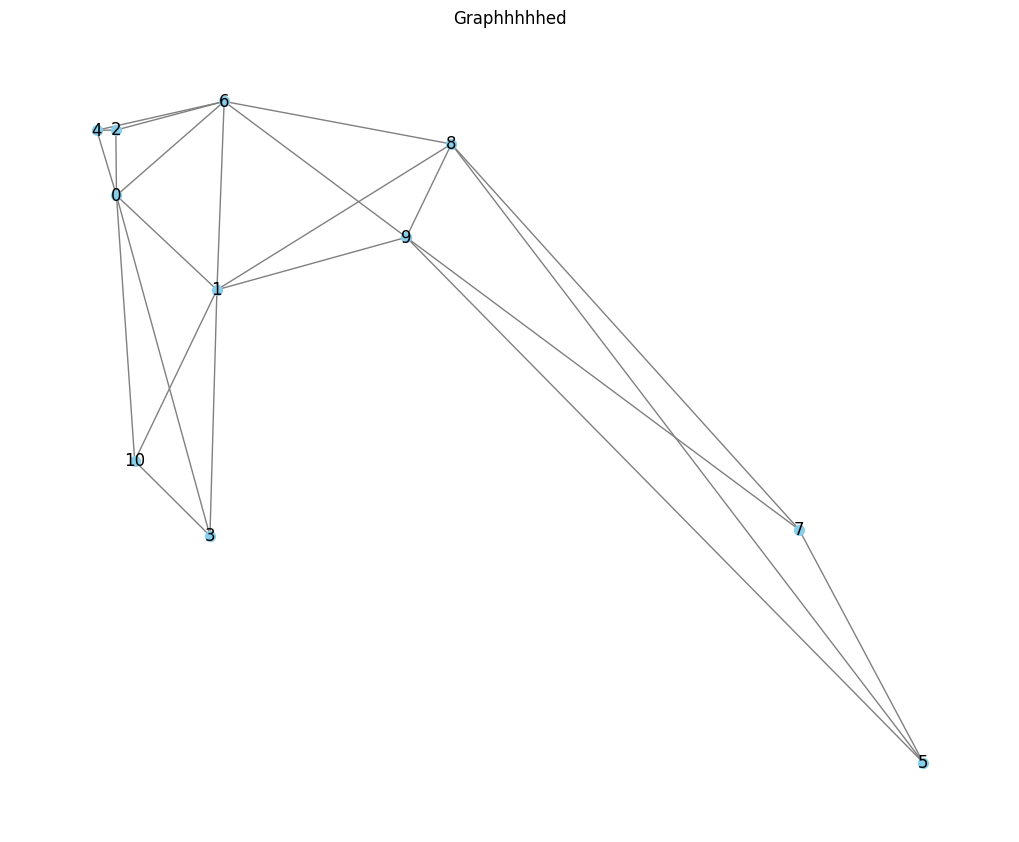

In [20]:
G = nx.Graph()
distances = {}
node_positions = {}

for i in range(len(data_frames)):
    coord1 = (data_frames[i]['Latitude'].iloc[0], data_frames[i]['Longitude'].iloc[0])
    node_positions[i] = coord1
    distances[i] = []

    for j in range(len(data_frames)):
        if i != j:
            coord2 = (data_frames[j]['Latitude'].iloc[0], data_frames[j]['Longitude'].iloc[0])
            distance = haversine(coord1, coord2)
            distances[i].append((distance, j))

for i, dist_list in distances.items():
    three_nearest = nsmallest(3, dist_list)
    for dist, j in three_nearest:
        G.add_edge(i, j, weight=dist)

plt.figure(figsize=(10, 8))
nx.draw(G, pos=node_positions, with_labels=True, node_size=50, node_color="skyblue", edge_color="gray")
plt.title("Graphhhhhed")
plt.show()


In [21]:
# import matplotlib.pyplot as plt
# import networkx as nx
# from heapq import nsmallest

# # Assuming lat_lons is your list of latitude-longitude pairs
# G = nx.Graph()
# distances = {}
# node_positions = {}

# for i in range(len(lat_lons)):
#     coord1 = lat_lons[i]
#     node_positions[i] = coord1
#     distances[i] = []

#     for j in range(len(lat_lons)):
#         if i != j:
#             coord2 = lat_lons[j]
#             distance = haversine(coord1, coord2)
#             distances[i].append((distance, j))

# for i, dist_list in distances.items():
#     three_nearest = nsmallest(3, dist_list)
#     for dist, j in three_nearest:
#         G.add_edge(i, j, weight=dist)

# plt.figure(figsize=(10, 8))
# nx.draw(G, pos=node_positions, with_labels=True, node_size=50, node_color="skyblue", edge_color="gray")
# plt.title("Graph Visualization")
# plt.show()


In [22]:
# directory_path = '/content/'
# pattern = re.compile(r'([0-9.-]+)_([0-9.-]+)\.csv')
# lat_lon_pairs = []
# for file_name in os.listdir(directory_path):
#     if file_name.endswith('.csv'):
#         match = pattern.search(file_name)
#         if match:
#             lat, lon = match.groups()
#             lat_lon_pairs.append((float(lat), float(lon)))
# print(lat_lon_pairs)

In [23]:
wisconsin_center = (44.5000, -89.5000)
map_wisconsin = folium.Map(location=wisconsin_center, zoom_start=7)
lat_lon_list = lat_lon_pairs

for lat, lon in lat_lon_list:
    folium.Marker(location=(lat, lon)).add_to(map_wisconsin)

NameError: ignored

In [ ]:

map_wisconsin.save('wisconsin_map.html')



In [24]:
example_tensor = stat_train_predictions[0]

In [25]:
example_tensor[0].shape

torch.Size([7, 1])

# Training Tensors and Testing tensor dataframes

In [26]:
columns = {}
for i, tensor in enumerate(stat_train_predictions):
    if isinstance(tensor, torch.Tensor) and tensor.shape == (6124, 7, 1):
        column = tensor[:, 6, :].squeeze()
        columns[f"{i+1}"] = column.numpy()
    else:
        raise ValueError(f"Item {i} in stat_train_predictions is not a tensor with shape [6124, 7, 1]")

df_tensor_11_train = pd.DataFrame(columns)

In [27]:
df_tensor_11_train

,1,2,3,4,5,6,7,8,9,10,11
0,27.849337,26.537422,28.226467,13.709249,26.747736,9.334329,20.749853,17.012323,33.682991,25.722874,25.785477
1,27.298910,20.587997,27.063681,16.605377,26.523626,9.628697,23.546944,16.177042,24.319868,27.420765,29.030987
2,25.396946,25.665848,18.003216,21.509314,19.768112,9.238588,19.685913,16.064245,28.474085,25.240356,22.888092
3,22.332785,28.510086,17.392698,23.625744,15.237929,10.341628,13.333921,16.158821,25.167767,24.415047,26.976437
4,17.501242,31.105398,21.272406,21.369799,18.215857,12.035717,14.836471,16.578201,24.895895,29.252037,22.853783
...,...,...,...,...,...,...,...,...,...,...,...
6119,9.874350,5.985471,13.576416,12.489887,11.445768,3.443812,3.878840,3.009309,4.429706,5.952649,6.476355
6120,11.014616,7.535805,15.757490,13.728390,12.145154,6.193758,3.817305,3.666426,3.855940,6.386640,6.982414
6121,7.826726,7.529466,12.827867,13.275902,15.938966,3.521087,3.949784,3.124824,3.903674,6.352011,8.239358
6122,8.870176,10.143253,15.373418,14.130253,15.188846,4.396543,9.070724,3.710540,3.891563,6.449229,9.566331


In [28]:
# df_tensor_11_train = pd.DataFrame(torch.cat(tuple(stat_train_predictions), axis=1).numpy())
df_tensor_11_test = pd.DataFrame(torch.cat(tuple(stat_test_predictions), axis=1).numpy())
df_tensor_11_test

,0,1,2,3,4,5,6,7,8,9,10
0,3.778727,12.149907,9.362420,2.252573,8.140174,6.183196,8.428992,4.394089,7.655705,3.744439,10.828461
1,4.019677,3.133956,7.081317,3.158169,5.912398,4.275067,9.893562,4.287591,2.797292,4.360768,11.004925
2,4.329110,2.621883,9.630044,3.566581,3.954726,4.847777,7.788726,4.941317,2.856449,3.844818,12.731842
3,4.951371,3.361044,4.309621,4.045372,4.246795,2.177105,9.069504,5.463791,2.774438,4.158319,10.365539
4,5.293151,2.227344,3.633762,10.928568,5.174106,3.233165,6.019764,5.217552,2.588069,4.548703,8.274844
...,...,...,...,...,...,...,...,...,...,...,...
2616,20.179855,18.357517,19.867628,20.105553,19.106863,5.636709,16.177296,3.489319,14.931091,13.428275,18.532352
2617,20.179855,18.357517,19.867628,20.105553,19.106863,5.636709,16.177296,3.489319,14.931091,15.093198,18.532352
2618,20.179855,18.357517,19.867628,20.105553,19.106863,5.636709,16.177296,3.489319,14.931091,16.468670,18.532352
2619,20.179855,18.357517,19.867628,20.105553,19.106863,5.636709,16.177296,3.489319,14.931091,15.363249,18.532352


In [29]:
print(len(df_tensor_11_test))
print(len(df_tensor_11_train))

2621
6124


In [30]:
targets = torch.tensor([df[['Value']].values for df in data_frames], dtype=torch.float)

In [31]:
targets.shape

torch.Size([11, 8760, 1])

In [32]:

df_tensor_11_test.columns = df_tensor_11_test.columns.astype(str)
df_tensor_11_test.columns = [str(int(col)+1) for col in df_tensor_11_test.columns]
combined_df = pd.concat([df_tensor_11_train, df_tensor_11_test], axis=0, ignore_index=True)
combined_df.head()

,1,2,3,4,5,6,7,8,9,10,11
0,27.849337,26.537422,28.226467,13.709249,26.747736,9.334329,20.749853,17.012323,33.682991,25.722874,25.785477
1,27.298910,20.587997,27.063681,16.605377,26.523626,9.628697,23.546944,16.177042,24.319868,27.420765,29.030987
2,25.396946,25.665848,18.003216,21.509314,19.768112,9.238588,19.685913,16.064245,28.474085,25.240356,22.888092
3,22.332785,28.510086,17.392698,23.625744,15.237929,10.341628,13.333921,16.158821,25.167767,24.415047,26.976437
4,17.501242,31.105398,21.272406,21.369799,18.215857,12.035717,14.836471,16.578201,24.895895,29.252037,22.853783


In [33]:
len(combined_df)

8745

In [34]:
num_nodes = 11
edge_index = torch.tensor(list(G.edges())).t().contiguous()
print(edge_index.shape)
x = torch.tensor([combined_df[col].values for col in combined_df], dtype=torch.float)
print(x.shape)
targets = torch.tensor([df['Value'].values for df in data_frames], dtype=torch.float)
targets = targets[:, :8745]
print(targets.shape)
data = Data(x=x, edge_index=edge_index, y=targets)

torch.Size([2, 23])
torch.Size([11, 8745])
torch.Size([11, 8745])


In [91]:
print(data.x)

tensor([[27.8493, 27.2989, 25.3969,  ..., 20.1799, 20.1799, 20.1799],
        [26.5374, 20.5880, 25.6658,  ..., 18.3575, 18.3575, 18.3575],
        [28.2265, 27.0637, 18.0032,  ..., 19.8676, 19.8676, 19.8676],
        ...,
        [33.6830, 24.3199, 28.4741,  ..., 14.9311, 14.9311, 14.9311],
        [25.7229, 27.4208, 25.2404,  ..., 16.4687, 15.3632, 19.8852],
        [25.7855, 29.0310, 22.8881,  ..., 18.5324, 18.5324, 18.5324]])


Epoch 0, Loss: 157.75953674316406, RMSE: 10.978766441345215, MAE: 8.214234352111816
Epoch 100, Loss: 114.9686279296875, RMSE: 10.61524486541748, MAE: 7.727258205413818
Epoch 200, Loss: 107.19207763671875, RMSE: 10.270414352416992, MAE: 7.264378547668457
Epoch 300, Loss: 100.05963134765625, RMSE: 9.94537353515625, MAE: 6.832880973815918
Epoch 400, Loss: 93.52156829833984, RMSE: 9.639541625976562, MAE: 6.433032035827637
Epoch 500, Loss: 87.52928161621094, RMSE: 9.352200508117676, MAE: 6.065149307250977
Epoch 600, Loss: 82.03677368164062, RMSE: 9.082572937011719, MAE: 5.727787494659424
Epoch 700, Loss: 77.00112915039062, RMSE: 8.829850196838379, MAE: 5.420868396759033
Epoch 800, Loss: 72.38265228271484, RMSE: 8.593214988708496, MAE: 5.145081520080566
Epoch 900, Loss: 68.14488220214844, RMSE: 8.371853828430176, MAE: 4.900912761688232
Epoch 1000, Loss: 64.25442504882812, RMSE: 8.164963722229004, MAE: 4.6870951652526855
Epoch 1100, Loss: 60.680789947509766, RMSE: 7.971761226654053, MAE: 4.49

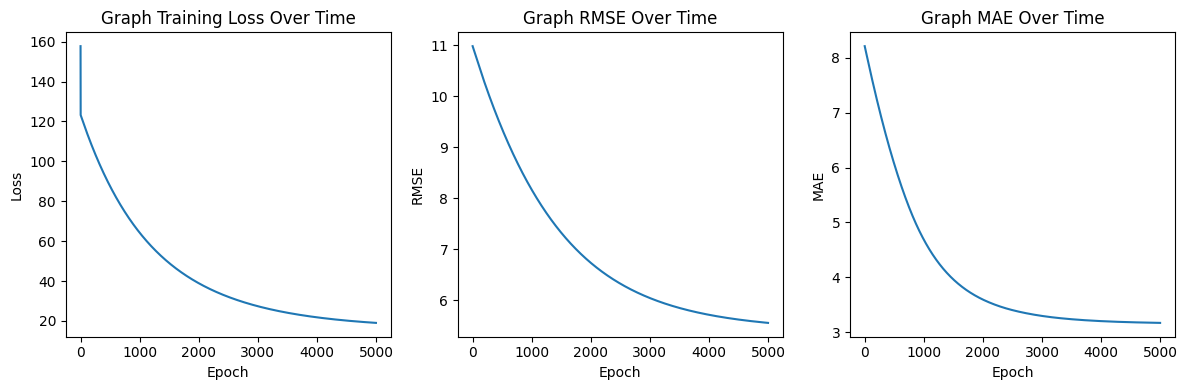

In [93]:
# Train/Test split
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_size = int(num_nodes * 0.7)

train_mask[:train_size] = True
test_mask[train_size:] = True

data.train_mask = train_mask
data.test_mask = test_mask

class BasicGNN(torch.nn.Module):
    def __init__(self, num_features, num_outputs):
        super(BasicGNN, self).__init__()
        self.conv1 = SAGEConv(num_features, 16)
        self.conv2 = SAGEConv(16, num_outputs)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x


model = BasicGNN(num_features=x.size(1), num_outputs=8745)
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

loss_values = []
rmse_values = []
mae_values = []
predictions_list = []
for epoch in range(5000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())

    # Calculate RMSE and MAE
    with torch.no_grad():
        model.eval()
        predictions = model(data)
        predictions_list.append(predictions)
        rmse = torch.sqrt(criterion(predictions[data.test_mask], data.y[data.test_mask]))
        mae = torch.mean(torch.abs(predictions[data.test_mask] - data.y[data.test_mask]))
        rmse_values.append(rmse.item())
        mae_values.append(mae.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, RMSE: {rmse.item()}, MAE: {mae.item()}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Graph Training Loss Over Time')

plt.subplot(1, 3, 2)
plt.plot(rmse_values)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Graph RMSE Over Time')

plt.subplot(1, 3, 3)
plt.plot(mae_values)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Graph MAE Over Time')

plt.tight_layout()
plt.show()

In [36]:
len(predictions_list[0][0])

8745

In [94]:
model.eval()
with torch.no_grad():
    pred = model(data).squeeze()
    test_pred = pred[data.test_mask]
    test_targets = data.y[data.test_mask]
    mse = torch.mean((test_pred - test_targets) ** 2)
    print(f'Mean Squared Error (MSE): {mse.item()}')
    rmse = torch.sqrt(mse)
    print(f'Root Mean Squared Error (RMSE): {rmse.item()}')
    target_mean = test_targets.mean()
    total_variance = torch.sum((test_targets - target_mean) ** 2)
    residual_variance = torch.sum((test_targets - test_pred) ** 2)
    r2_score = 1 - (residual_variance / total_variance)
    print(f'R² Score: {r2_score.item()}')
    embeddings = model(data).detach().cpu().numpy()



Mean Squared Error (MSE): 30.850475311279297
Root Mean Squared Error (RMSE): 5.554320335388184
R² Score: 0.4185349941253662


In [95]:
guess = embeddings[6]
guess_series = pd.Series(guess)

In [96]:
len(embeddings)

11

In [97]:
embeddings[0] == embeddings[1]

array([ True,  True,  True, ...,  True,  True,  True])

In [98]:
embeddings[6]

array([19.56348 , 19.30581 , 19.474144, ..., 16.522915, 16.556871,
       16.571543], dtype=float32)

In [77]:
truth = combined_df['7']

In [78]:
truth == guess_series

0       False
1       False
2       False
3       False
4       False
        ...  
8740    False
8741    False
8742    False
8743    False
8744    False
Length: 8745, dtype: bool

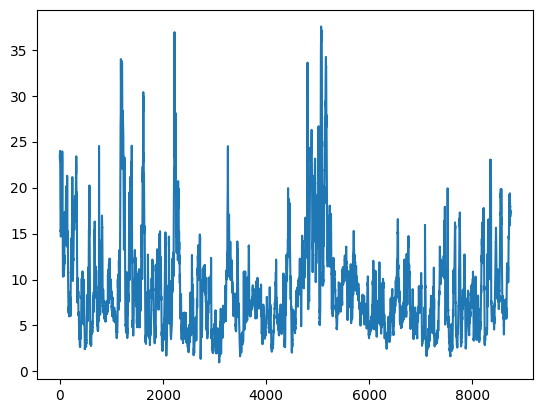

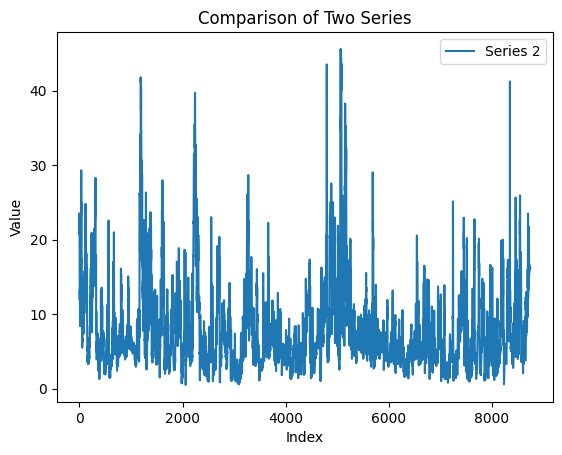

In [81]:
plt.plot(guess_series, label='Series 1')
plt.show()
plt.plot(truth, label='Series 2')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Two Series')
plt.legend()

# Show the plot
plt.show()


In [80]:
import torch

# Assuming your model outputs a single value per node for regression
pred = model(data)

# Apply the test mask to both predictions and labels
pred_test = pred[data.test_mask]
labels_test = data.y[data.test_mask]

# Calculate Mean Squared Error (MSE) as an example metric
mse = torch.mean((pred_test - labels_test) ** 2)
rmse = torch.sqrt(mse)  # Root Mean Squared Error
mae = torch.mean(torch.abs(pred_test - labels_test))  # Mean Absolute Error

print(f'MSE: {mse.item():.4f}, RMSE: {rmse.item():.4f}, MAE: {mae.item():.4f}')


MSE: 85.3061, RMSE: 9.2361, MAE: 5.9436


# might be useful idk (Graveyard coded)

In [ ]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.CrossEntropyLoss()

# for epoch in range(50):
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)
#     loss = criterion(out[data.train_mask], data.y[data.train_mask])
#     loss.backward()
#     optimizer.step()
#     print(f'Epoch {epoch}, Loss: {loss.item()}')


In [ ]:
# edge_index = torch.tensor(list(G.edges)).t().contiguous()
# # stensor = tensor([[ 0,  0,  0,  0,  0,  0,  0,  7,  7,  7,  8,  8,  8,  8, 11, 11, 11,  1,1, 14,  2,  3,  3, 16, 16,  4,  4,  4,  9,  9,  9,  5,  5, 13,  6],[ 7,  8, 11,  1,  3, 14, 16,  2, 15,  8,  1,  2, 15, 14,  3, 10, 16, 14,4,  4, 15, 16, 10,  6, 10,  9,  5, 12,  5, 12, 13, 13, 12,  6, 10]])
# x = torch.tensor([[df['Value'].mean(), df['Value'].std()] for df in data_frames], dtype=torch.float)
data = Data(x=x, edge_index=edge_index)
# data = Data(x=[17, 2], edge_index=[2, 35])
num_features = 2
num_classes = 8760

# regression_targets = torch.tensor([df[['Value']].values for df in data_frames], dtype=torch.float)
# targets_tensor = torch.tensor(regression_targets, dtype=torch.float)
# data = Data(edge_index=edge_index, x=node_features)
# data.y = targets_tensor
# print(f'this is the true data {len(targets_tensor)}')
# # this is the true data 17
# print(data.shape)
# print(data.edge_index)

In [ ]:
# num_nodes = data.num_nodes
# train_size = int(num_nodes * 0.8)

# train_mask = torch.zeros(num_nodes, dtype=torch.bool)
# train_mask[:train_size] = True

# num_features = 2
# num_classes = 8760


# data.train_mask = train_mask
# data.y = targets_tensor.view(-1)


# class BasicGNN(torch.nn.Module):
#     def __init__(self, num_features):
#         super(BasicGNN, self).__init__()
#         self.conv1 = SAGEConv(num_features, 16)
#         self.conv2 = SAGEConv(16, 1)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = F.relu(self.conv1(x, edge_index))
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)
#         return x.squeeze()


# model = BasicGNN(num_features)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.MSELoss()

# # Training loop
# for epoch in range(50):
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)
#     # Reshape out if necessary
#     out = out.view_as(data.y)

#     # Check shapes
#     assert out.shape[0] == data.num_nodes, "Output size does not match number of nodes"

#     # Compute loss
#     loss = criterion(out[data.train_mask], data.y[data.train_mask])
#     loss.backward()
#     optimizer.step()
#     print(f'Epoch {epoch}, Loss: {loss.item()}')

In [ ]:
# edge_index = torch.tensor(list(G.edges)).t().contiguous()

# x = torch.tensor([[df['Value'].mean(), df['Value'].std()] for df in data_frames], dtype=torch.float)
# regression_targets = torch.tensor([df[['Value']].values for df in data_frames], dtype=torch.float)
# targets_tensor = torch.tensor([df[['Value']].values for df in data_frames], dtype=torch.float)
# targets_tensor = targets_tensor.view(-1)
# targets = [df['Value'].mean() for df in data_frames]
# data = Data(x=x, edge_index=edge_index, y=targets_tensor)
# num_nodes = data.num_nodes
# test_mask = torch.zeros(num_nodes, dtype=torch.bool)
# test_mask[int(0.8 * num_nodes):] = True  # Assuming the last 20% of the data is for testing
# data.test_mask = test_mask

# data.y = torch.tensor(targets, dtype=torch.float)
# num_nodes = data.num_nodes  # Total number of nodes in your graph

# num_nodes = data.num_nodes
# train_size = int(num_nodes * 0.8)

# train_mask = torch.zeros(num_nodes, dtype=torch.bool)
# train_mask[:train_size] = True
# edge_index = torch.tensor(list(G.edges)).t().contiguous()
# x = torch.tensor([[df['Value'].mean(), df['Value'].std()] for df in data_frames], dtype=torch.float)
# targets = [df['Value'].mean() for df in data_frames]
# data = Data(x=x, edge_index=edge_index, y=torch.tensor(targets, dtype=torch.float))
# data.train_mask = train_mask
# num_nodes = data.num_nodes
# train_size = int(num_nodes * 0.8)

# train_mask = torch.zeros(num_nodes, dtype=torch.bool)
# train_mask[:train_size] = True

# num_features = 2

# class BasicGNN(torch.nn.Module):
#     def __init__(self, num_features):
#         super(BasicGNN, self).__init__()
#         self.conv1 = SAGEConv(num_features, 16)
#         self.conv2 = SAGEConv(16, 1)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = F.relu(self.conv1(x, edge_index))
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)
#         return x.squeeze()

# model = BasicGNN(num_features)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.MSELoss()

# # Training loop
# for epoch in range(20000):
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)
#     out = out.view_as(data.y)
#     assert out.shape[0] == data.num_nodes, "Output size does not match number of nodes"
#     loss = criterion(out[data.train_mask], data.y[data.train_mask])
#     loss.backward()
#     optimizer.step()
#     #print(f'Epoch {epoch}, Loss: {loss.item()}')


In [ ]:
# import torch.optim as optim
# import torch.utils.data as data

# def r2_score(predicted, target):
#     mean_target = torch.mean(target)
#     total_variance = torch.sum((target - mean_target)**2)
#     residual_variance = torch.sum((target - predicted)**2)
#     r_squared = 1 - (residual_variance / total_variance)

#     return r_squared.item()

# for i in range(len(station_data)):
#   X_train = torch.tensor(station_train_dataset[i][0], dtype=torch.float)
#   y_train = torch.tensor(station_train_dataset[i][1], dtype=torch.float)
#   X_test = torch.tensor(station_test_dataset[i][0], dtype=torch.float)
#   y_test = torch.tensor(station_test_dataset[i][1], dtype=torch.float)

#   loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
#   n_epochs = 100
#   loss_fn = nn.MSELoss()
#   input_size = 1
#   stat_train_predictions = []
#   stat_test_predictions = []
#   def models(loader, X_train, y_train, X_test, y_test):
#     model = LSTM_Model(input_size)
#     optimizer = optim.Adam(model.parameters(), lr=0.01)
#     losses = []
#     for epoch in range(n_epochs):
#         model.train()
#         avg_loss = []
#         for X_batch, y_batch in loader:
#             y_pred = model(X_batch)
#             loss = loss_fn(y_pred, y_batch)
#             avg_loss.append(loss.detach().numpy())
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#         losses.append(np.mean(avg_loss))
#         # Validation
#         model.eval()
#         with torch.no_grad():
#             y_pred = model(X_train)
#             stat_train_predictions.append(y_pred)
#             train_rmse = np.sqrt(loss_fn(y_pred, y_train))
#             r2_score_train = r2_score(y_pred, y_train)
#             y_pred = model(X_test)
#             stat_test_predictions.append(y_pred)
#             test_rmse = np.sqrt(loss_fn(y_pred, y_test))
#             r2_score_test = r2_score(y_pred, y_test)

#         print("Epoch %d: train RMSE %.4f, test RMSE %.4f, train R2 %.4f, test R2 %.4f" % (epoch, train_rmse, test_rmse, r2_score_train, r2_score_test))
#     return model, losses

#   print("PM 2.5 Model")
#   pm25_model, pm25_losses = models(loader, X_train, y_train, X_test, y_test)
#   plot(pm25_model, station_data[0], train_size, X_train, y_train, X_test, y_test)

In [ ]:
# import torch
# from torch_geometric.data import Data
# import torch.nn.functional as F
# from torch_geometric.nn import SAGEConv
# import torch.optim as optim

# # Assuming G is your graph object and combined_df is your DataFrame of predicted values
# edge_index = torch.tensor(list(G.edges())).t().contiguous()

# # Change x to have stat train and test predictions
# x = torch.tensor([combined_df[col].values for col in combined_df], dtype=torch.float).t()

# # This one is the targets
# targets = torch.tensor([df['Value'].values for df in data_frames], dtype=torch.float).t()
# data = Data(x=x, edge_index=edge_index, y=targets)
# num_nodes = data.num_nodes

# # Train/Test split
# train_mask = torch.zeros(num_nodes, dtype=torch.bool)
# test_mask = torch.zeros(num_nodes, dtype=torch.bool)
# train_size = int(num_nodes * 0.8)

# train_mask[:train_size] = True
# test_mask[train_size:] = True

# data.train_mask = train_mask
# data.test_mask = test_mask

# # Basic GNN Model
# class BasicGNN(torch.nn.Module):
#     def __init__(self, num_features):
#         super(BasicGNN, self).__init__()
#         self.conv1 = SAGEConv(num_features, 16)
#         self.conv2 = SAGEConv(16, 1)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = F.relu(self.conv1(x, edge_index))
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)
#         return x.squeeze()

# # Ensure num_features matches the number of features for each node
# model = BasicGNN(num_features=x.size(1))
# optimizer = optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.MSELoss()

# for epoch in range(2000):
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)
#     loss = criterion(out[data.train_mask], data.y[data.train_mask])
#     loss.backward()
#     optimizer.step()


In [ ]:
# train_losses = []
# val_losses = []

# for epoch in range(2000):
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)
#     train_loss = criterion(out[data.train_mask], data.y[data.train_mask])
#     train_loss.backward()
#     optimizer.step()
#     train_losses.append(train_loss.item())

#     model.eval()
#     with torch.no_grad():
#         out = model(data)
#         val_loss = criterion(out[data.test_mask], data.y[data.test_mask])
#         val_losses.append(val_loss.item())

#     if epoch % 100 == 0:
#         print(f'Epoch {epoch}, Train Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}')
